# Fast rise direct deconvolution

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

from numpy.fft import rfft
from numpy.fft import rfftfreq
from numpy.fft import irfft

from lmfit import fit_report
from lmfit import Minimizer
from lmfit import Model
from lmfit import Parameters
from lmfit.models import ConstantModel

from scipy.signal import resample
from scipy.signal import convolve
from scipy.signal import tukey

from uncertainties import unumpy
from uncertainties import ufloat

## Signal import and frequency analysis

In [2]:
data_file = 'data/raw_data/selected_g2/20170529_FWMg2_MPD_MPDGated_4GHzOsci_4MHzBlueDetuned.dat'
# 'encode/20170529_FWMg2_MPD_MPDGated_4GHzOsci_4MHzBlueDetuned.dat'

# import oscilloscope data into time and counts vectors. cut off the edges
Dt, counts = np.flipud(np.genfromtxt(data_file, skip_header=5, delimiter=',')).T
Dt_step = np.abs(np.mean(np.diff(Dt)))

# usable_range = range(len(Dt))
usable_range = range(543, 4994)
counts = counts[usable_range]
Dt = -Dt[usable_range]

counts_err = np.sqrt(counts)
counts_u = unumpy.uarray(counts, counts_err)
print('Time resolution: {:.3e}'.format(Dt_step))

Time resolution: 1.000e-11


<IPython.core.display.Javascript object>


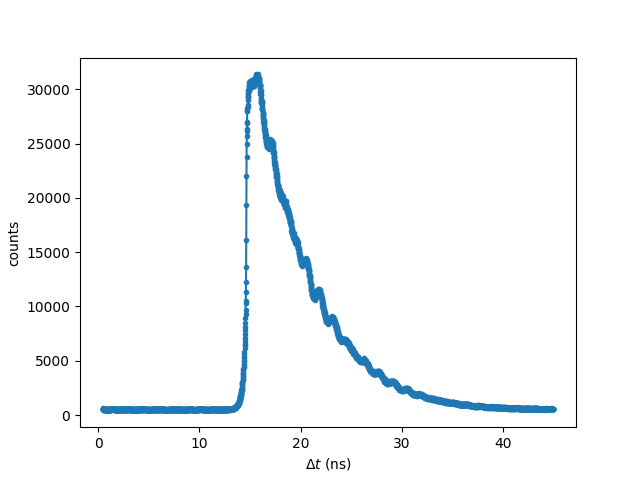

In [3]:
plt.figure('FWM data, time resolution: {:.3g} ns'.format(np.mean(np.diff(Dt))* 1e9))
plt.plot(Dt*1e9, counts, '.-')
plt.xlabel(r'$\Delta t$ (ns)')
plt.ylabel('counts');

## Detector transfer function

<IPython.core.display.Javascript object>


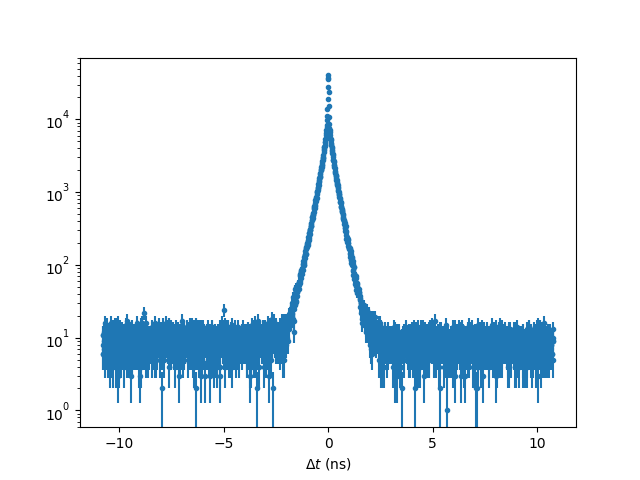

In [4]:
mpd_datafile = 'data/raw_data/MPD_characterization/F1pmp1actrigger.txt'
Dt_mpd, counts_mpd = np.genfromtxt(mpd_datafile, delimiter=',', skip_header=5).T
Dt_mpd_step = np.mean(np.diff(Dt_mpd))

# drop zero bins and center the MPD response function
peak_idx = np.argmax(counts_mpd)
mpd_center = counts_mpd[4:peak_idx + (peak_idx - 5)]
mpd_t = (np.arange(len(mpd_center)) - len(mpd_center)//2 - 1) * Dt_mpd_step

# poissonian error
mpd_error = np.sqrt(mpd_center)

# sets the floor range where accidental counts are the main component
flat_range = list(range(500)) + list(range(len(mpd_t)-500, len(mpd_t)))

plt.figure()
plt.errorbar(mpd_t * 1e9, mpd_center, yerr=mpd_error, fmt='.')
plt.xlabel(r'$\Delta t$ (ns)');
plt.yscale('log')

### Baseline removal

[[Model]]
    (((Model(constant, prefix='offset_') + Model(exponential, prefix='a_')) + Model(exponential, prefix='b_')) + Model(gaussian, prefix='c_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 308
    # data points      = 2159
    # variables        = 8
    chi-square         = 5282.05013
    reduced chi-square = 2.45562535
    Akaike info crit   = 1947.59070
    Bayesian info crit = 1993.00991
[[Variables]]
    offset_c:     7.81887519 +/- 0.10471039 (1.34%) (init = 1)
    a_decay:      0.27442600 +/- 0.00161536 (0.59%) (init = 1)
    a_amplitude:  6539.88187 +/- 95.2736513 (1.46%) (init = 100)
    b_decay:      0.06780135 +/- 0.00298675 (4.41%) (init = 1)
    b_amplitude:  7305.58025 +/- 303.999090 (4.16%) (init = 100)
    c_sigma:      0.01826659 +/- 4.0790e-04 (2.23%) (init = 0.1)
    c_center:    -0.00112182 +/- 6.4523e-04 (57.52%) (init = 0)
    c_amplitude:  1275.56665 +/- 49.8442384 (3.91%) (init = 1000)
    c_fwhm:       0.04301454 +/- 9.60

<IPython.core.display.Javascript object>


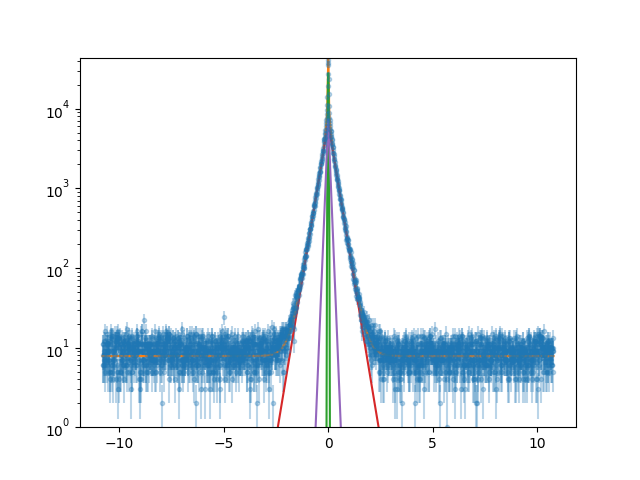

In [5]:
# Model of the detector response
from lmfit.models import ExponentialModel, GaussianModel, LorentzianModel
response_model = (ConstantModel(prefix='offset_') +
                  ExponentialModel(prefix='a_') +
                  ExponentialModel(prefix='b_')  +
                  GaussianModel(prefix='c_')
                 )

p_peak = response_model.make_params()
p_peak['offset_c'].set(value=min(mpd_center))
p_peak['a_decay'].set(value=1)
p_peak['a_amplitude'].set(value=1e2)
p_peak['b_decay'].set(value=1)
p_peak['b_amplitude'].set(value=1e2)
p_peak['c_amplitude'].set(value=1e3)
p_peak['c_sigma'].set(value=.1)
p_peak['c_center'].set(value=0, vary=1)

mpd_result = response_model.fit(mpd_center,
                                x=np.abs(mpd_t * 1e9),
                                params=p_peak,
                                weights=1 / mpd_error
                               )
print(mpd_result.fit_report())
comps = mpd_result.eval_components()
plt.figure()
plt.errorbar(mpd_t * 1e9, mpd_center, yerr=mpd_error, alpha=.3, fmt='.')
plt.plot(mpd_t * 1e9, mpd_result.best_fit);
plt.plot(mpd_t * 1e9, comps['c_']);
plt.plot(mpd_t * 1e9, comps['a_']);
plt.plot(mpd_t * 1e9, comps['b_']);
plt.ylim(min(mpd_center))
plt.yscale('log')

In [7]:
# Defining the normalized response function, including errors
mpd_counts_u = unumpy.uarray(mpd_center, mpd_error) - ufloat(mpd_result.params['offset_c'].value,
                                                      mpd_result.params['offset_c'].stderr)

# normalization
norm_u = np.sum(mpd_counts_u)
mpd_u = mpd_counts_u / norm_u
mpd_error = unumpy.std_devs(mpd_u)
mpd = unumpy.nominal_values(mpd_u)

## Fourier transform of the detector response and angular frequency axis

In [9]:
# match length of signal and detector response
l_signal = len(counts)
l_mpd = len(mpd)
extension = np.zeros(int((l_signal-l_mpd) / 2))
mpd_ex = np.concatenate((extension, mpd, extension))
mpd_error_ex = np.concatenate((extension, mpd_error, extension))
print('Signal lengt: {}, New response vector length: {}'.format(l_signal, len(mpd_ex)))

Signal lengt: 4451, New response vector length: 4451


## Deconvolution

In [10]:
# high frequency filter
def winn(x, cutoff):
    retval = np.exp(-x / cutoff)
    retval /= retval[0]
    return retval

cutoff = 400
winn_vec = winn(np.arange(np.ceil(l_signal/2)), cutoff)

In [11]:
def deconvolution(signal, det_response, winn=None):
    signal_fft = rfft(signal)
    signal_fft /= signal_fft[0]
    det_fft = rfft(det_response)
    det_fft /= det_fft[0]
    if winn is not None:
        signal_fft = signal_fft * winn
    return irfft(signal_fft / det_fft)

### Bootstrapping

In [12]:
# sampling using Poissonian statistics
samples = 1e4
counts_prop = np.array([np.random.poisson(k, int(samples)) for k in counts]).T

# applying the deconvolution for every sample
dec_prop = np.array([deconvolution(k, mpd_ex, winn_vec)
                         for k in counts_prop])

# extract the resulting deconvoluted signal and corresponding error
tt = np.mean(dec_prop.T, 1)
tt_err = np.std(dec_prop.T, 1)

# fix for the rollover of the inverse fourier transform
tt = np.concatenate((tt[len(tt) // 2:], tt[:len(tt) // 2 + 1]))
tt_err = np.concatenate((tt_err[len(tt_err) // 2:], tt_err[:len(tt_err) // 2 + 1]))

<IPython.core.display.Javascript object>


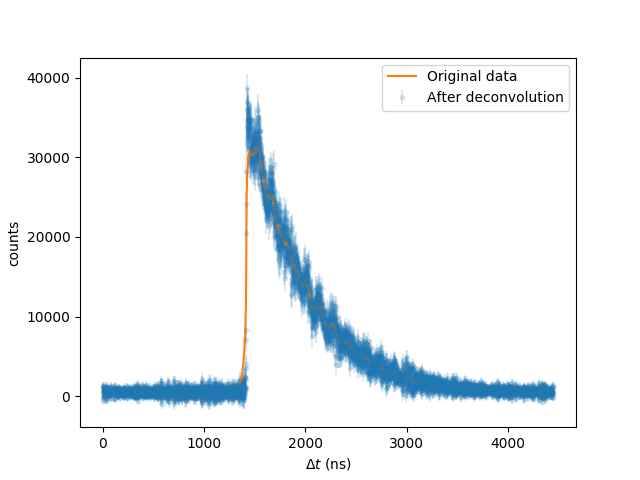

In [13]:
plt.figure('Comparison of time correlation before and after deconvolution with detectors response')
plt.errorbar(np.arange(len(tt)), tt*sum(counts), yerr=tt_err*sum(counts), fmt='.', alpha=.15, label='After deconvolution');
plt.plot(counts, '-', label='Original data')
plt.xlabel(r'$\Delta t$ (ns)')
plt.ylabel('counts')
plt.legend();

## Fitting

### Fit function

In [14]:
def jump(x, alpha):
    # rising edge
    return np.tanh(x / alpha) / 2 + .5

def rise_decay_f(x, alpha, t0, tau):
    x = x - t0
    retval = jump(x, alpha) * np.exp(-x / tau)
    return retval / max(retval)

def rise_time(alpha):
    # return 90/10 rise time from the edge
    c = np.log(1.8/.2) / 2
    return alpha * c * 2

# fit model from function
rise_decay_model = ConstantModel(prefix='amplitude_') * Model(rise_decay_f) + ConstantModel(prefix='offset_')

### Parameter choice and results

90/10 rise time from fit: 0.0673+/-0.0044 ns

[[Model]]
    ((Model(constant, prefix='amplitude_') * Model(rise_decay_f)) + Model(constant, prefix='offset_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 79
    # data points      = 4451
    # variables        = 5
    chi-square         = 3522.60172
    reduced chi-square = 0.79230808
    Akaike info crit   = -1031.21774
    Bayesian info crit = -999.213323
[[Variables]]
    alpha:        0.03060799 +/- 0.00198073 (6.47%) (init = 0.1)
    t0:           14.6228069 +/- 0.00114887 (0.01%) (init = 14)
    tau:          5.47344808 +/- 0.02254137 (0.41%) (init = 6)
    offset_c:     1.8602e-05 +/- 5.2017e-07 (2.80%) (init = 2.37401e-05)
    amplitude_c:  0.00163923 +/- 5.8853e-06 (0.36%) (init = 0.001756747)
[[Correlations]] (unreported correlations are < 0.100)
    C(tau, amplitude_c)      = -0.622
    C(tau, offset_c)         = -0.509
    C(alpha, amplitude_c)    = -0.238
    C(offset_c, amplitude_c) =  0.127

<IPython.core.display.Javascript object>


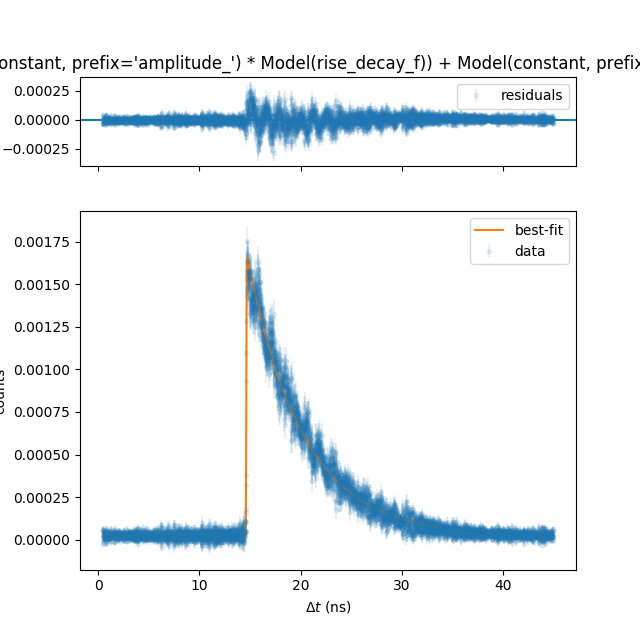

<IPython.core.display.Javascript object>


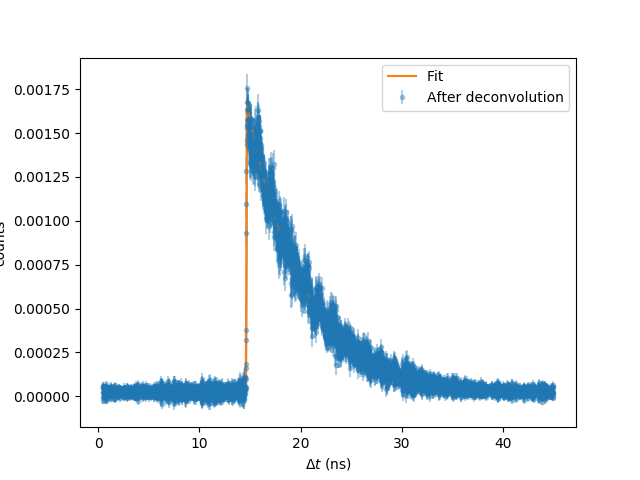

In [15]:
bp = Parameters()
p.add('alpha', .1)
p.add('t0', 14)
p.add('tau', 6)
p.add('offset_c', np.mean(tt[:200]), vary=1)
p.add('amplitude_c', max(tt))

fit_result = rise_decay_model.fit(tt, x=Dt*1e9, params=p, weights= 1 / tt_err)

print('90/10 rise time from fit: {:.2u} ns\n'.format(rise_time(ufloat(fit_result.params['alpha'].value,
                                                                      fit_result.params['alpha'].stderr))))
print(fit_result.fit_report())
fit_result.plot(xlabel=r'$\Delta t$ (ns)',
                ylabel='counts',
                datafmt='.',
                data_kws={'alpha':.1});

plt.figure()
dely = fit_result.eval_uncertainty(sigma=3)
plt.fill_between(Dt*1e9, fit_result.best_fit-dely, fit_result.best_fit+dely, color="#ABABAB")
plt.errorbar(Dt*1e9, tt, yerr=tt_err, fmt='.', alpha=.35, label='After deconvolution')
plt.plot(Dt*1e9, fit_result.best_fit, '-', label='Fit');
plt.xlabel(r'$\Delta t$ (ns)')
plt.ylabel('counts')
plt.legend();

In [25]:
fit_result.best_fit.max(), fit_result.best_fit.min()
# fit_result.best_values['t0'] - rise_time(fit_result.params['alpha'].value/2), fit_result.best_values['t0'] + rise_time(fit_result.params['alpha'].value/2)

fit_result.best_fit.min() + fit_result.best_fit.ptp()*.1
fit_result.best_fit.min() + fit_result.best_fit.ptp()*.9

0.0014939091691120701

## Save data to file

In [133]:
with open('data/processed_data/quantum-jump.dat', 'w') as f:
    f.write('#Dt\tcounts\tcounts_err\t'
            'deconv\tdeconv_err\t'
            'fit\tfit_uncert\n')
    [f.write(('{}\t'*6 + '{}\n').format(t, c, c_e, dc, dc_e, ff, ff_e))
     for t, c, c_e, dc, dc_e, ff, ff_e
     in zip(Dt*1e9, counts, counts_err, tt, tt_err, fit_result.best_fit, dely)]